## Getting the class boundary through Black Box

This Ipython Notebook deals with fitting a black box model on a binary classifiable dataset (both linear and non linear as well as 2 dimensional and multi dimensional). A Minimal Distance Pair Algorithm is defined which works as follows:
1. Generate a random dataset under some confined boundaries.
2. Generate labels for the random dataset using the black box
3. Compute distance between the data points of each of the two classes
4. Choose N points such that the points which are of different classes and closer to each other have high probability of being chosen
5. Generate a dataset out of those close points.
6. Fit a new model on the new dataset and find its accuracy on the original dataset.

The basic idea behind this algorithm is that the points which belong to different classes and are close to one another will provide a sense of the hyperplane which is dividing the further two classes. With this sense of hyperplane we can create our new model such that it enables the new model to learn approximately the plane of separation of the black box. In this way the new model can intuitively work better on the original dataset

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from collections import Counter
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
def generate_random_without_constraints(feature_names, data_size):
    '''
    Input: Data, Feature Names, Size of Random Data
    Output: Random Data
    
    Generates random dataset of size data_size
    Random dataset is generated from normal
    distribution with specified high and low values
    '''
    
    df = {}
    for i in range(len(feature_names)):
        df[feature_names[i]] = np.random.normal(size=data_size)
    random_dataset = pd.DataFrame(data=df, columns=feature_names)
    
    return random_dataset

In [4]:
def generate_random(orig_data, feature_names, data_size):
    '''
    Input: Data, Feature Names, Size of Random Data
    Output: Random Data
    
    Generates random dataset of size data_size
    Random dataset is generated from normal
    distribution with specified high and low values
    '''
    
    df = {}
    for i in range(len(feature_names)):
        low = np.min(orig_data[:, i])
        high = np.max(orig_data[:, i])
        df[feature_names[i]] = np.random.uniform(low=low, high=high, size=data_size)
    random_dataset = pd.DataFrame(data=df, columns=feature_names)
    
    return random_dataset

In [5]:
def euclidean_dist(x1, x2):
    
    '''
    Input: x1 and x2 are numpy arrays or scalars
    Output: Euclidean distance between two high 
    dimensional arrays
    '''
    
    dist = np.sqrt(np.sum(np.square(x1 - x2)))
    return dist

In [6]:
def get_distance(X, y, label1, label2):
    
    '''
    Input: Numpy array representing data points
    Two labels between whose data points the distance
    needs to be found
    
    Output: Euclidean distance between each pair of data
    points
    '''
    
    distance = []
    points = []
    for x1 in X[y == label1, :]:
        for x2 in X[y == label2, :]:
            distance.append(euclidean_dist(x1, x2))
            points.append((x1, x2))
    return points, distance

In [18]:
def plotData(X, xaxis, yaxis, ax, labels=None, feature_names=None, title='Graph'):
    
    '''
    Input: Numpy array of data points
    Feature number for x axis
    Feature number for y axis
    labels representing the classes
    feature_names for features along both axes
    
    Output: Plot of the features 
    '''
    
    try:
        ax.scatter(X[:, xaxis], X[:, yaxis], c = labels, cmap=plt.cm.brg)
    except:
        ax.scatter(X[:, xaxis], X[:, yaxis])
        
    try:
        ax.set_xlabel(data.feature_names[xaxis])
        ax.set_ylabel(data.feature_names[yaxis])
    except:
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
    ax.set_title(title)

In [8]:
def labelInfo(labels):
    
    '''
    Produces label information
    '''
    
    dist = Counter(labels).most_common()
    for tup in dist:
        print 'Label: ', tup[0], 'Count: ', tup[1]

In [9]:
def applyAlgo(X_random, y_random, label1, label2, num_points=1000, num_choose=100):
    
    '''
    Apply the algorithm of minimum euclidean distances
    '''
    
    points, distance = get_distance(X_random, y_random, label1, label2)
    assert len(points) == len(distance)
    args = np.argsort(distance)[0:num_points]
    points = np.asarray(points)
    random_points = points[np.random.choice(args, num_choose)]
    random_points = random_points.reshape((num_choose*2, X_random.shape[1]))
    label = [label1 if x%2 == 0 else label2 for x in np.arange(random_points.shape[0])]
    
    return random_points, label

## Linearly Separable Data

Blackbox score on the random dataset:  0.99
Whitebox score when trained with random dataset:  0.99
Label:  1 Count:  508
Label:  0 Count:  492


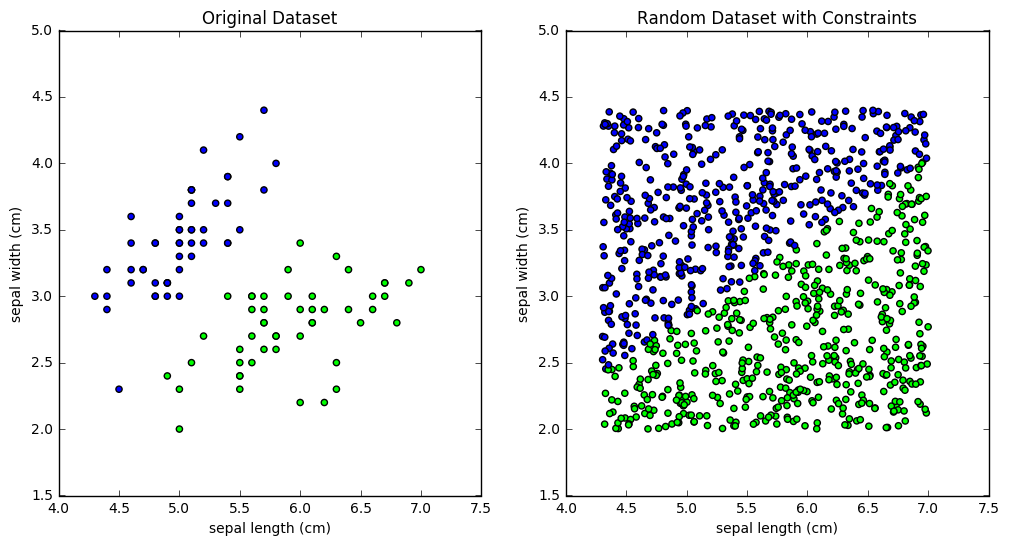

In [15]:
## Data Wrangling
data = datasets.load_iris()
X = data.data[:, :2]
y = data.target
X = X[(y == 0) | (y == 1), :]
y = y[(y == 0) | (y == 1)]

## Plotting the data
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
plotData(X, 0, 1, ax, y, feature_names=data.feature_names, title='Original Dataset')

## Fitting black box to original data
blackbox = LogisticRegression()
blackbox.fit(X, y)
print 'Blackbox score on the random dataset: ', blackbox.score(X, y)

## Generating random samples
X_random = generate_random(X, data.feature_names[0:2], data_size=1000).values
y_random = blackbox.predict(X_random)
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Whitebox score when trained with random dataset: ', whitebox.score(X, y)

## Getting label information
labelInfo(y_random)
ax = fig.add_subplot(122)
plotData(X_random, 0, 1, ax, labels=y_random, feature_names=data.feature_names, title='Random Dataset with Constraints')

## Applying the algorithm
new_data, new_labels = applyAlgo(X_random, y_random, 0, 1)

(1000, 2)


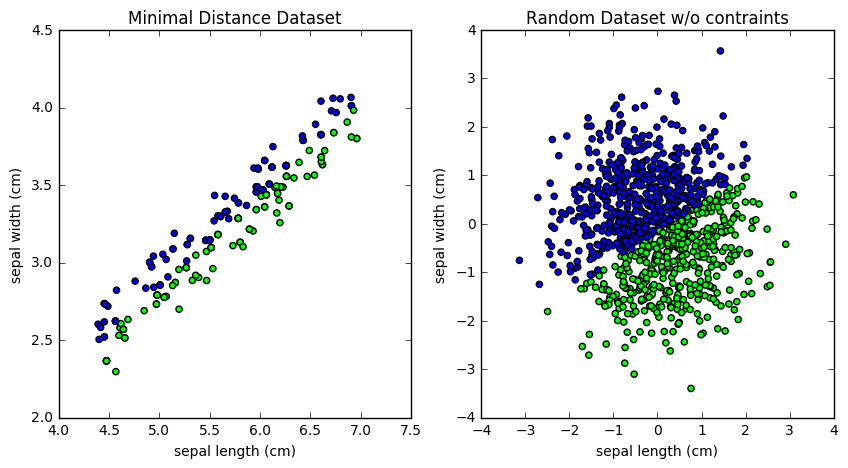

In [49]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plotData(new_data, 0, 1, ax, new_labels, feature_names=data.feature_names, title="Minimal Distance Dataset")

## Purely Random Dataset
X_random = generate_random_without_constraints(data.feature_names[0:2], data_size=1000).values
print X_random.shape
y_random = blackbox.predict(X_random)
ax = fig.add_subplot(122)
plotData(X_random, 0, 1, ax, labels=y_random, feature_names=data.feature_names, title='Random Dataset w/o contraints')

In [12]:
score = []
for i in range(1, 11):
    X_random = generate_random_without_constraints(feature_names=data.feature_names[0:2], data_size=1000)
    y_random = blackbox.predict(X_random)
    whitebox = LogisticRegression()
    whitebox.fit(X_random, y_random)
    score.append(whitebox.score(X, y))
    print 'Iteration: {}\n Accuracy: {}'.format(i, whitebox.score(X, y))
print 'Mean Score: ', np.mean(score)

Iteration: 1
 Accuracy: 0.99
Iteration: 2
 Accuracy: 0.99
Iteration: 3
 Accuracy: 0.99
Iteration: 4
 Accuracy: 0.98
Iteration: 5
 Accuracy: 0.98
Iteration: 6
 Accuracy: 0.98
Iteration: 7
 Accuracy: 0.99
Iteration: 8
 Accuracy: 0.99
Iteration: 9
 Accuracy: 0.97
Iteration: 10
 Accuracy: 0.99
Mean Score:  0.985


In [13]:
whitebox = LogisticRegression()
whitebox.fit(new_data,new_labels)
print 'Score of whitebox on original dataset: ', whitebox.score(X, y)

Score of whitebox on original dataset:  0.99


** Score is equivalent with the black box. The model works fine on simple dimensions ** :)

## Non Linearly Separable Data

In [10]:
import tensorflow as tf

In [11]:
tf.reset_default_graph()

In [12]:
with tf.variable_scope("Input") as scope:
    input_data = tf.placeholder(dtype=tf.float32, shape=[None, 2], name="Input_data")
    labels = tf.placeholder(dtype=tf.float32, shape=[None,2], name="labels")

In [13]:
with tf.variable_scope("hidden_layer") as scope:
    w = tf.get_variable(dtype=tf.float32, shape=[2, 128], initializer=tf.random_normal_initializer(), name="weights")
    b = tf.get_variable(dtype=tf.float32, shape=[128], initializer=tf.random_normal_initializer(), name="biases")
    out = tf.nn.relu(tf.matmul(input_data, w) + b)

In [14]:
with tf.variable_scope("output_layer") as scope:
    w = tf.get_variable(dtype=tf.float32, shape=[128, 2], initializer=tf.random_normal_initializer(), name="weights")
    b = tf.get_variable(dtype=tf.float32, shape=[2], initializer=tf.random_normal_initializer(), name="biases")
    softmax = tf.nn.softmax(tf.matmul(out,w) + b)

In [15]:
with tf.variable_scope("loss") as scope:
    loss = tf.reduce_mean(-tf.reduce_sum(labels*tf.log(softmax), reduction_indices=[1]))

In [16]:
with tf.variable_scope("optimizer") as scope:
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

Epoch: 1000
 Loss: 0.407465755939
Epoch: 2000
 Loss: 0.0994688570499
Epoch: 3000
 Loss: 0.0449815951288
Epoch: 4000
 Loss: 0.0239599235356
Epoch: 5000
 Loss: 0.0137612633407
Label:  0 Count:  500
Label:  1 Count:  500
Whitebox score when trained on the random dataset:  1.0


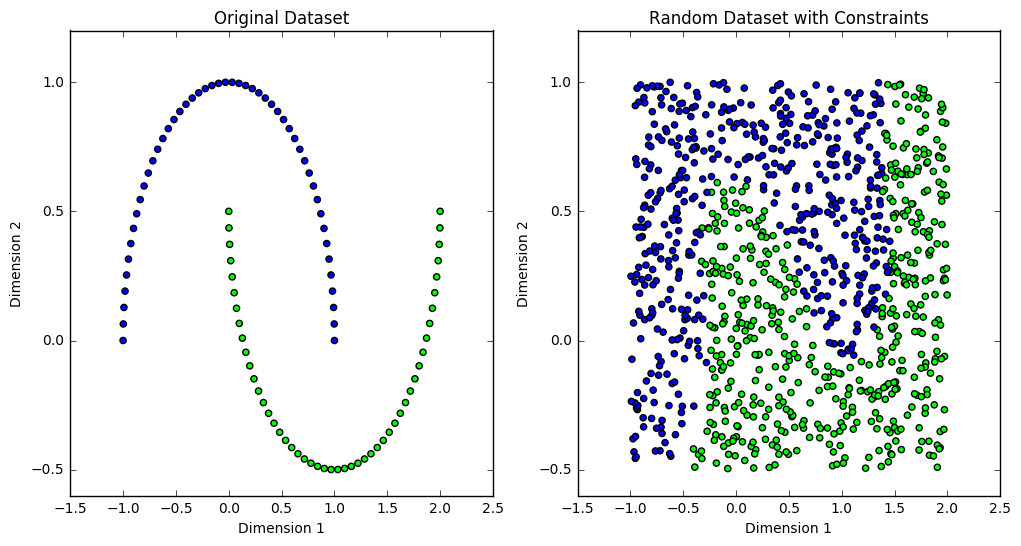

In [19]:
## Data Wrangling
data = datasets.make_moons()
X, y = data
color = y
y = pd.get_dummies(y)
feature_names = ['feature1', 'feature2']

## Plotting the data
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
plotData(X, 0, 1, ax, color,title='Original Dataset', feature_names=['Dimension 1', 'Dimension 2'])

## Generating random samples
X_random = generate_random(X, feature_names, data_size=1000).values
X_random_ = generate_random_without_constraints(feature_names, data_size=1000).values

## Fitting the black box and generating labels for random dataset
l, i = 1000, 1
epsilon = 1e-2
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    while l > epsilon:
        
        _, l = sess.run([optimizer, loss], feed_dict={input_data:X, labels:y})
        
        if i % 1000 == 0:
            
            print 'Epoch: {}\n Loss: {}'.format(i, l)
        i += 1
    
    ## Generating labels for random data
    y_random = sess.run([softmax], feed_dict={input_data:X_random})
    y_random_ = sess.run([softmax], feed_dict={input_data:X_random_})

## Getting label information
y_random = np.argmax(y_random[0], 1)
labelInfo(y_random)

## Performance of white box when trained with random data
whitebox = RandomForestClassifier()
whitebox.fit(X_random, y_random)
print 'Whitebox score when trained on the random dataset: ', whitebox.score(X, data[1])

ax = fig.add_subplot(122)
plotData(X_random, 0, 1, ax, labels=y_random, feature_names=['Dimension 1', 'Dimension 2'], title='Random Dataset with Constraints')

## Applying the algorithm
new_data, new_labels = applyAlgo(X_random, y_random, 0, 1)

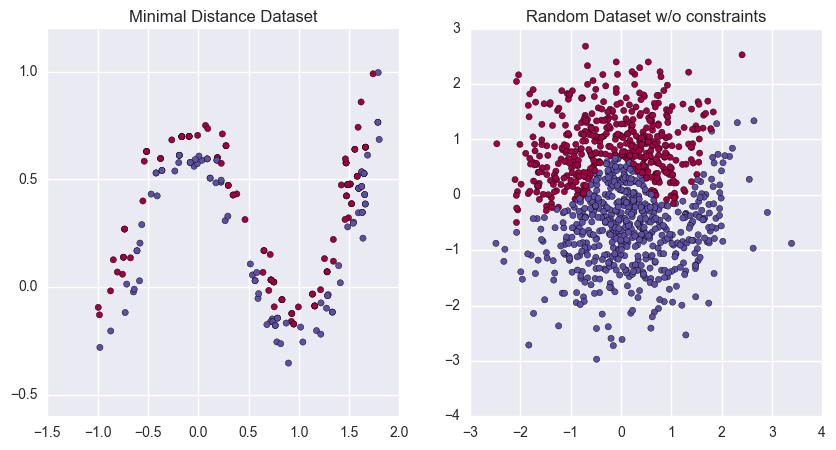

In [22]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plotData(new_data, 0, 1, ax, new_labels, title="Minimal Distance Dataset")

ax = fig.add_subplot(122)
plotData(X_random_, 0, 1, ax, np.argmax(y_random_[0], 1), title="Random Dataset w/o constraints")

In [23]:
whitebox = RandomForestClassifier()
whitebox.fit(new_data, pd.get_dummies(new_labels))
print 'Score of Whitebox on original data', whitebox.score(X, y)

Score of Whitebox on original data 0.96


In [27]:
ax = fig.add_subplot(122)
X_random = generate_random_without_constraints(feature_names=feature_names, data_size=1000)
y_random = blackbox.predict(X_random.values)
plotData(X_random.values, 0, 1, ax, y_random, title="Random Dataset w/o constraints")

In [47]:
score = []
for i in range(1, 11):
    X_random = generate_random_without_constraints(feature_names=feature_names, data_size=1000)
    y_random = blackbox.predict(X_random.values)
    whitebox = RandomForestClassifier()
    whitebox.fit(X_random.values, y_random)
    s = whitebox.score(X, np.argmax(y.values,1))
    score.append(s)
    print 'Iteration: {}\n Accuracy: {}'.format(i, s)
print 'Mean Score: ', np.mean(score)

Iteration: 1
 Accuracy: 0.83
Iteration: 2
 Accuracy: 0.85
Iteration: 3
 Accuracy: 0.84
Iteration: 4
 Accuracy: 0.83
Iteration: 5
 Accuracy: 0.84
Iteration: 6
 Accuracy: 0.84
Iteration: 7
 Accuracy: 0.84
Iteration: 8
 Accuracy: 0.81
Iteration: 9
 Accuracy: 0.86
Iteration: 10
 Accuracy: 0.84
Mean Score:  0.838


** Works well on non linear data, although the data is still in 2 dimensions **

## High Dimensional Data

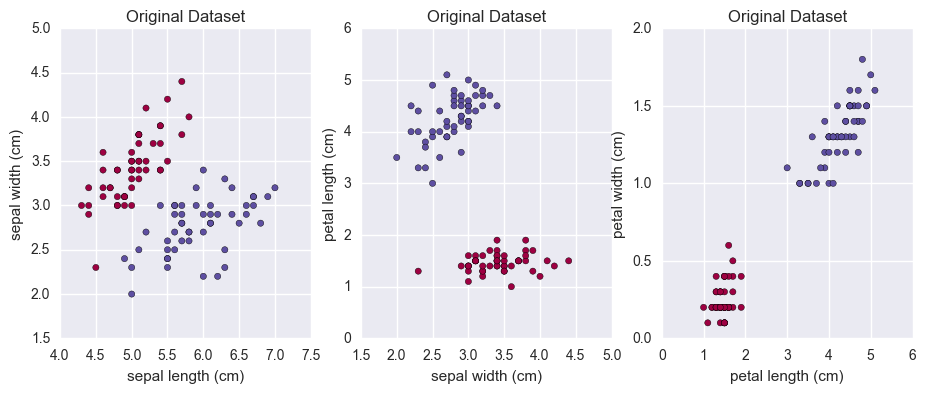

Whitebox performance when trained with random dataset:  1.0
Label:  1 Count:  566
Label:  0 Count:  434


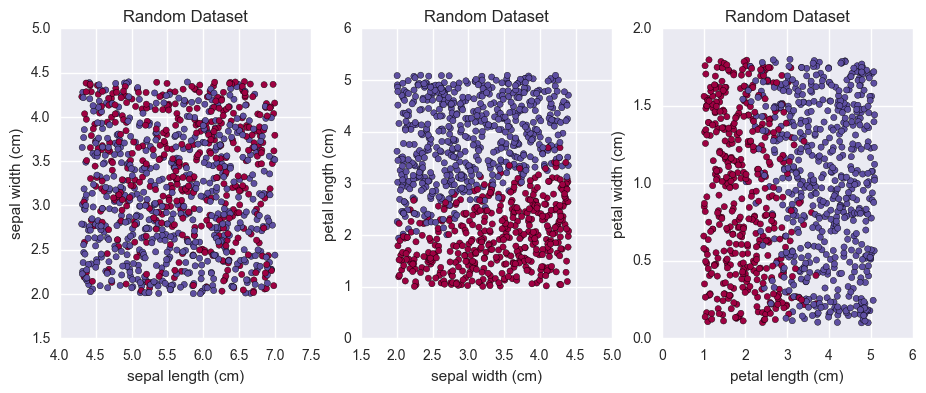

In [48]:
## Data Wrangling
data = datasets.load_iris()
X = data.data
y = data.target
X = X[(y == 0) | (y == 1), :]
y = y[(y == 0) | (y == 1)]

## Plotting the data
title = 'Original Dataset'
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(131)
plotData(X, 0, 1, ax, y, data.feature_names, title=title)
ax = fig.add_subplot(132)
plotData(X, 1, 2, ax, y, data.feature_names, title=title)
ax = fig.add_subplot(133)
plotData(X, 2, 3, ax, y, data.feature_names, title=title)
plt.show()

## Fitting the black box model
blackbox = LogisticRegression()
blackbox.fit(X, y)

## Generating random samples
X_random = generate_random(X, data.feature_names, data_size=1000).values
y_random = blackbox.predict(X_random)

## Performance of whitebox with random dataset
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Whitebox performance when trained with random dataset: ', whitebox.score(X, y)

## Getting label information
labelInfo(y_random)

## Plotting the random  data
title = 'Random Dataset'
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(131)
plotData(X_random, 0, 1, ax, labels=y_random, feature_names=data.feature_names, title=title)
ax = fig.add_subplot(132)
plotData(X_random, 1, 2, ax, labels=y_random, feature_names=data.feature_names, title=title)
ax = fig.add_subplot(133)
plotData(X_random, 2, 3, ax, labels=y_random, feature_names=data.feature_names, title=title)
plt.show()

## Applying the algorithm
new_data, new_labels = applyAlgo(X_random, y_random, 0, 1)

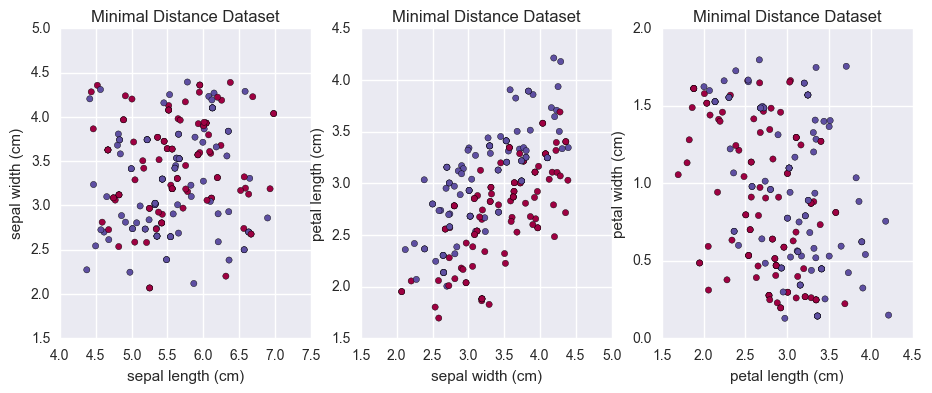

In [49]:
title='Minimal Distance Dataset'
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(131)
plotData(new_data, 0, 1, ax, labels=new_labels, feature_names=data.feature_names, title=title)
ax = fig.add_subplot(132)
plotData(new_data, 1, 2, ax, labels=new_labels, feature_names=data.feature_names, title=title)
ax = fig.add_subplot(133)
plotData(new_data, 2, 3, ax, labels=new_labels, feature_names=data.feature_names, title=title)
plt.show()

The minimal distance points generated are not so obviously separated into the two classes but it can be hypothesized that a plane which perfectly separates the classes (** in high dimensions **) can be represented by this new dataset. 

In [50]:
whitebox = LogisticRegression()
whitebox.fit(new_data, new_labels)
print 'Score of whiteboard on the original data: ', whitebox.score(X, y)

Score of whiteboard on the original data:  1.0


## Very High Dimensional Data
e.g. heart.csv

In [51]:
from sklearn.svm import SVC

In [52]:
## Data Wrangling
data = pd.read_csv('../data/heart.csv')
data['famhist'] = data['famhist'].map({'Absent': 0, 'Present': 1})
y = data.pop('chd').values
feature_names = data.columns
X = data.values

## Fitting the black box model
blackbox = LogisticRegression()
blackbox.fit(X, y)
print 'Black Box accuracy on the original dataset: ', blackbox.score(X, y)

## Generating random samples
X_random = generate_random(X, feature_names, data_size=1000).values
y_random = blackbox.predict(X_random)

## Whitebox performance with the random dataset
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Whitebox performance when trained on random examples: ', whitebox.score(X, y)
## Getting label information
labelInfo(y_random)

## Applying the algorithm
new_data, new_labels = applyAlgo(X_random, y_random, 0, 1)

Black Box accuracy on the original dataset:  0.733766233766
Whitebox performance when trained on random examples:  0.720779220779
Label:  0 Count:  531
Label:  1 Count:  469


In [53]:
whitebox = LogisticRegression()
whitebox.fit(new_data, new_labels)
print 'White Box accuracy on the original dataset', whitebox.score(X, y)

White Box accuracy on the original dataset 0.727272727273


## On different models

In [54]:
import copy

In [55]:
def flowModels(models, X, y, feature_names, data_size=1000):
    accuracy_wb = []
    accuracy_bb = []
    accuracy_random = []
    
    for model in models:
        print '*'*30
        print model
        
        blackbox = copy.deepcopy(model)
        blackbox.fit(X, y)
        score = blackbox.score(X, y)
        print 'Black Box accuracy on the original dataset: ', score
        accuracy_bb.append(score)

        ## Generating random samples
        X_random = generate_random(X, feature_names, data_size=data_size).values
        y_random = blackbox.predict(X_random)
        
        whitebox = copy.deepcopy(model)
        whitebox.fit(X_random, y_random)
        score = whitebox.score(X,y)
        accuracy_random.append(score)

        ## Getting label information
        labelInfo(y_random)

        ## Applying the algorithm
        new_data, new_labels = applyAlgo(X_random, y_random, 0, 1, num_points=data_size, num_choose=100)
        
        whitebox = copy.deepcopy(model)
        whitebox.fit(new_data, new_labels)
        score = whitebox.score(X, y)
        print 'White Box accuracy on the original dataset', score
        print '*'*30
        accuracy_wb.append(score)
        
    return accuracy_bb, accuracy_wb, accuracy_random

In [56]:
## Data Wrangling
data = pd.read_csv('../data/heart.csv')
data['famhist'] = data['famhist'].map({'Absent': 0, 'Present': 1})
y = data.pop('chd').values
feature_names = data.columns
X = data.values

In [78]:
import pickle as pkl
with open('../../../Dataset/Census/train.pkl', 'rb') as fp:
    data = pkl.load(fp)
with open('../../../Dataset/Census/label.pkl', 'rb') as fp:
    label = pkl.load(fp)
feature_names = data.columns
X = data.values
y = label
print X.shape, y.shape

(32561, 107) (32561,)


In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [80]:
models = [RandomForestClassifier(), LogisticRegression(), LinearDiscriminantAnalysis(), KNeighborsClassifier()]

In [85]:
ac_bb, ac_wb, ac_r = flowModels(models, X, y, feature_names)

******************************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Black Box accuracy on the original dataset:  0.986763305795
Label:  1 Count:  671
Label:  0 Count:  329
White Box accuracy on the original dataset 0.759773962716
******************************
******************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Black Box accuracy on the original dataset:  0.797948465956
Label:  1 Count:  945
Label:  0 Count

In [82]:
rcParams['figure.figsize'] = (10, 5)

In [83]:
print ac_bb
print ac_wb
print ac_r

[0.98740824913239766, 0.79794846595620528, 0.84217315193022324, 0.83578514173397622]
[0.6732594207794601, 0.79773348484383155, 0.81330425969718378, 0.31285894167869538]
[0.73127360953287679, 0.79051626178557166, 0.82700162771413654, 0.26516384631921625]


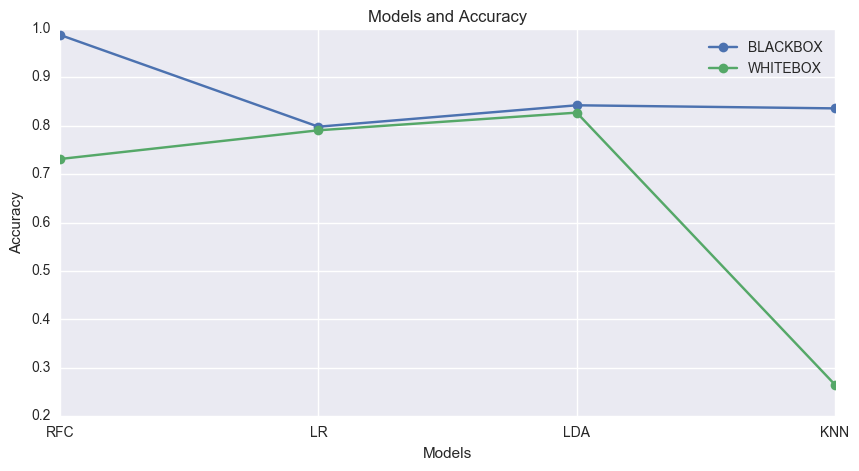

In [84]:
my_xticks = ['RFC', 'LR', 'LDA', 'KNN']
x = np.arange(len(my_xticks))
plt.xticks(x, my_xticks)
plt.plot(x, ac_bb, '-o', label='BLACKBOX')
# plt.plot(x, ac_wb, '-o', label='WHITEBOX')
plt.plot(x, ac_r, '-o', label='WHITEBOX')
plt.title('Models and Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Using Random Data without Constraints (zero mean uniform distribution)

### Iris Dataset with 2 Dimensions

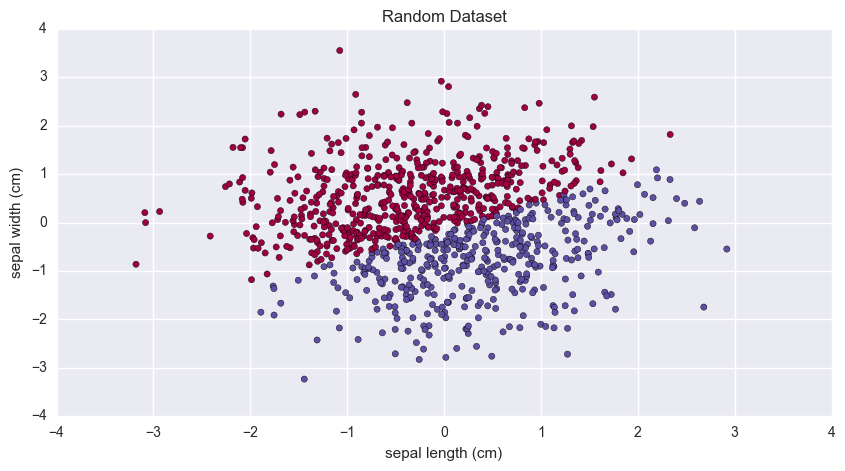

In [10]:
data = datasets.load_iris()
X = data.data[:, 0:2]
y = data.target

X = X[(y == 0) | (y == 1), :]
y = y[(y == 0) | (y == 1)]

X_random = generate_random_without_constraints(feature_names=data.feature_names[0:2], data_size=1000).values

blackbox = LogisticRegression()
blackbox.fit(X, y)
y_random = blackbox.predict(X_random)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plotData(X_random, 0, 1, ax, labels=y_random, feature_names=data.feature_names[0:2], title='Random Dataset')

In [11]:
## Used whitebox as Logistic Regressor
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Score on original dataset using LogisticRegression: ', whitebox.score(X, y)
## Used whitebox as Random Forest Classifier
whitebox = RandomForestClassifier()
whitebox.fit(X_random, y_random)
print 'Score on original dataset using RandomForestClassifier : ', whitebox.score(X, y)

Score on original dataset using LogisticRegression:  0.99
Score on original dataset using RandomForestClassifier :  0.5


### Iris Dataset with all dimensions

[]

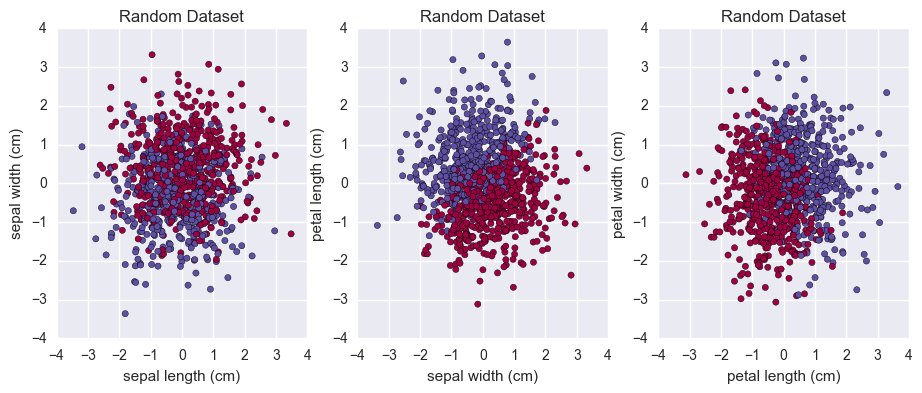

In [12]:
data = datasets.load_iris()
X = data.data
y = data.target

X = X[(y == 0) | (y == 1), :]
y = y[(y == 0) | (y == 1)]

X_random = generate_random_without_constraints(feature_names=data.feature_names, data_size=1000).values

blackbox = LogisticRegression()
blackbox.fit(X, y)
y_random = blackbox.predict(X_random)

fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(131)
plotData(X_random, 0, 1, ax, labels=y_random, feature_names=data.feature_names[0:2], title='Random Dataset')
ax = fig.add_subplot(132)
plotData(X_random, 1, 2, ax, labels=y_random, feature_names=data.feature_names[1:3], title='Random Dataset')
ax = fig.add_subplot(133)
plotData(X_random, 2, 3, ax, labels=y_random, feature_names=data.feature_names[2:], title='Random Dataset')
plt.plot()

In [13]:
## Used whitebox as Logistic Regressor
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Score on original dataset using LogisticRegression: ', whitebox.score(X, y)
## Used whitebox as Random Forest Classifier
whitebox = RandomForestClassifier()
whitebox.fit(X_random, y_random)
print 'Score on original dataset using RandomForestClassifier : ', whitebox.score(X, y)

Score on original dataset using LogisticRegression:  1.0
Score on original dataset using RandomForestClassifier :  0.5


### Heart Dataset with all Dimensions

In [14]:
data = pd.read_csv('../data/heart.csv')
data['famhist'] = data['famhist'].map({"Absent":0, "Present":1})
y = data.pop('chd')
feature_names = data.columns
X = data.values

X_random = generate_random_without_constraints(feature_names=feature_names, data_size=1000).values

blackbox = LogisticRegression()
blackbox.fit(X, y)
y_random = blackbox.predict(X_random)

In [15]:
## Used whitebox as Logistic Regressor
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Score on original dataset using LogisticRegression: ', whitebox.score(X, y)
## Used whitebox as Random Forest Classifier
whitebox = RandomForestClassifier()
whitebox.fit(X_random, y_random)
print 'Score on original dataset using RandomForestClassifier : ', whitebox.score(X, y)

Score on original dataset using LogisticRegression:  0.34632034632
Score on original dataset using RandomForestClassifier :  0.65367965368


### Blackbox and Whitebox showdown

In [16]:
data = pd.read_csv('../data/heart.csv')
data['famhist'] = data['famhist'].map({"Absent":0, "Present":1})
y = data.pop('chd')
feature_names = data.columns
X = data.values

In [21]:
blackbox = [LogisticRegression(), RandomForestClassifier(), RidgeClassifier(), LinearDiscriminantAnalysis(),
            QuadraticDiscriminantAnalysis()]
whitebox = [LogisticRegression(), RandomForestClassifier(), RidgeClassifier(), LinearDiscriminantAnalysis(),
            QuadraticDiscriminantAnalysis()]
names = ['LR', 'RFC', 'Ridge', 'LDA', 'QDA']

#### Constrained Random Values

In [22]:
X_random = generate_random(X, feature_names, data_size=1000)
print X_random.shape

(1000, 9)


In [23]:
i = 0
accuracy = {}
for bb in blackbox:
    print 'Black Box: ', names[i]
    bb.fit(X, y)
    y_random = bb.predict(X_random)
    acc = []
    
    for wb in whitebox:
        wb.fit(X_random, y_random)
        acc.append(wb.score(X, y))
    
    accuracy[names[i]] = acc
    i += 1

Black Box:  LR
Black Box:  RFC
Black Box:  Ridge
Black Box:  LDA
Black Box:  QDA


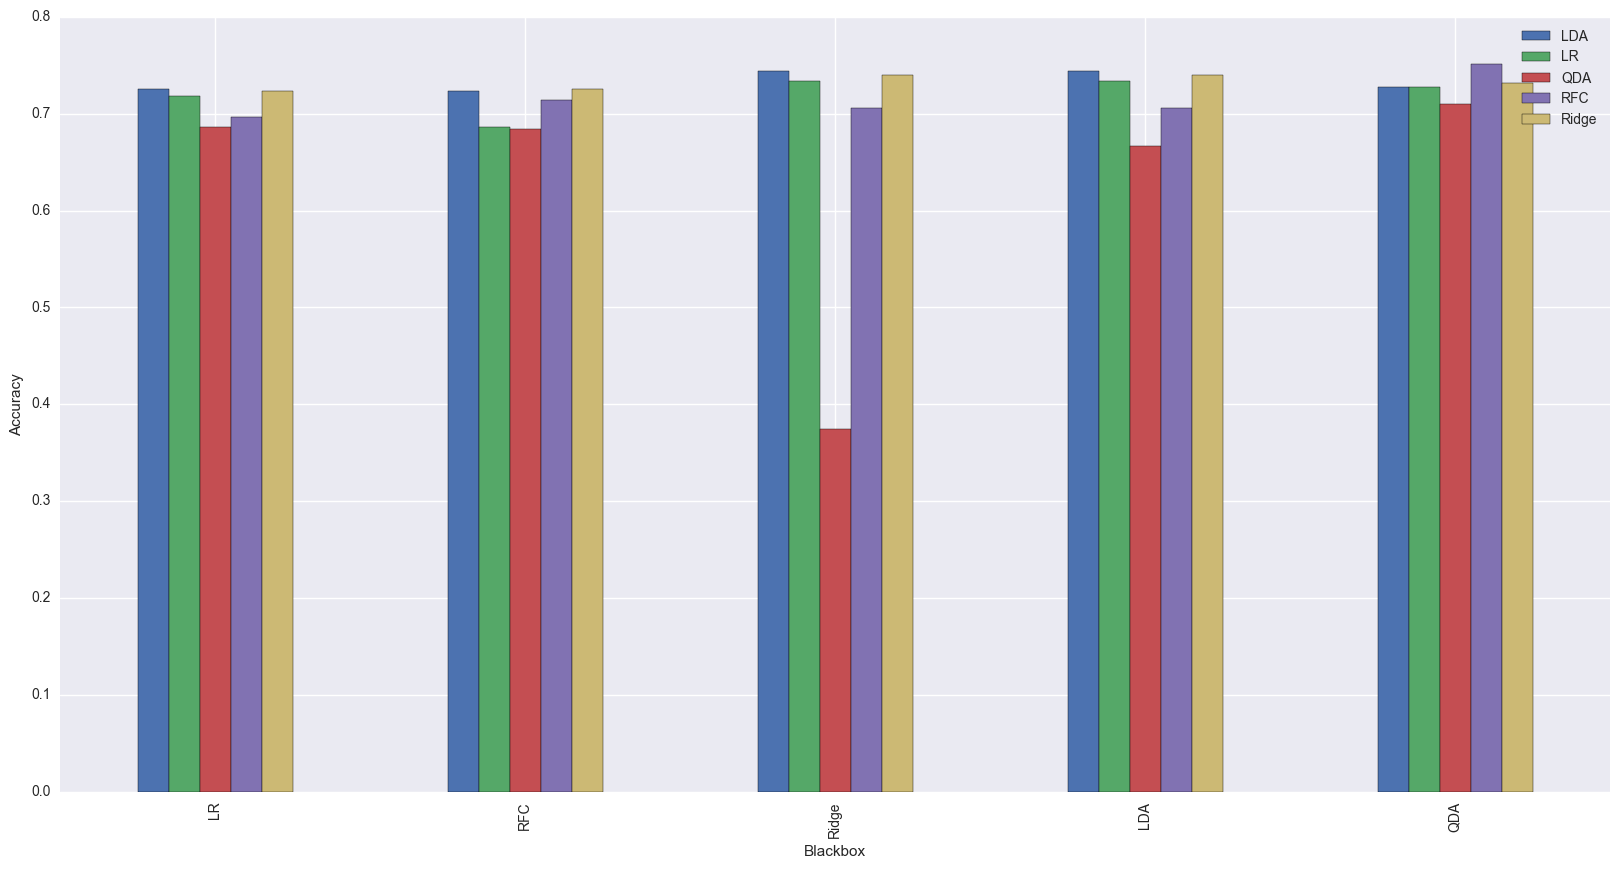

In [26]:
table = pd.DataFrame(accuracy, index=names)
table.plot(kind='bar')
plt.xlabel('Blackbox')
plt.ylabel('Accuracy')

In [27]:
table.head()

,LDA,LR,QDA,RFC,Ridge
LR,0.725108,0.718615,0.686147,0.696970,0.722944
RFC,0.722944,0.686147,0.683983,0.714286,0.725108
Ridge,0.744589,0.733766,0.374459,0.705628,0.740260
LDA,0.744589,0.733766,0.666667,0.705628,0.740260
QDA,0.727273,0.727273,0.709957,0.751082,0.731602


#### Unconstrained random values

In [55]:
blackbox = [LogisticRegression(), RandomForestClassifier(), RidgeClassifier(), LinearDiscriminantAnalysis(),
            QuadraticDiscriminantAnalysis()]
whitebox = [LogisticRegression(), RandomForestClassifier(), RidgeClassifier(), LinearDiscriminantAnalysis(),
            QuadraticDiscriminantAnalysis()]
names = ['LR', 'RFC', 'Ridge', 'LDA', 'QDA']

In [56]:
X_random = generate_random_without_constraints(feature_names, data_size=1000)
print X_random.shape

(1000, 9)


In [57]:
i = 0
accuracy = {}
for bb in blackbox:
    print 'Black Box: ', names[i]
    bb.fit(X, y)
    y_random = bb.predict(X_random)
    acc = []
    
    try:
        for wb in whitebox:
            wb.fit(X_random, y_random)
            acc.append(wb.score(X, y))
        accuracy[names[i]] = acc
    except:
        print 'Error occured'
    i += 1

Black Box:  LR
Black Box:  RFC
Black Box:  Ridge
Error occured
Black Box:  LDA
Error occured
Black Box:  QDA


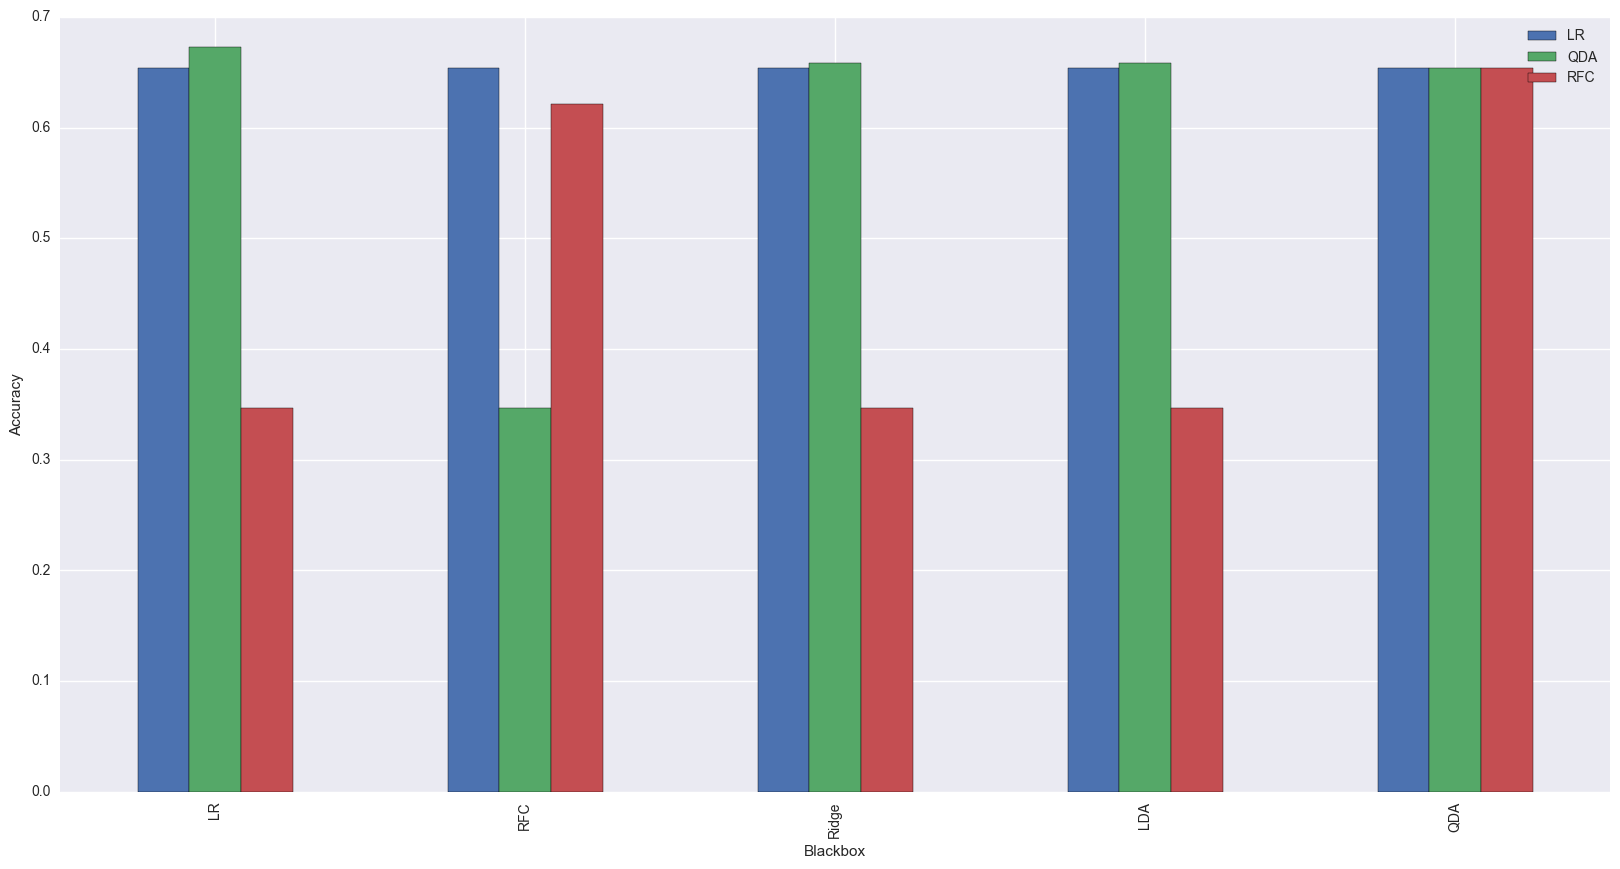

In [58]:
table = pd.DataFrame(accuracy, index=names)
table.plot(kind='bar')
plt.xlabel('Blackbox')
plt.ylabel('Accuracy')

In [59]:
table.head()

,LR,QDA,RFC
LR,0.65368,0.673160,0.346320
RFC,0.65368,0.346320,0.621212
Ridge,0.65368,0.658009,0.346320
LDA,0.65368,0.658009,0.346320
QDA,0.65368,0.653680,0.653680


### Generating population from minimal distance points

We need to populate the dataset across the dividing plane. Naive idea is to add in each of the data point a delta (noise)

In [117]:
import copy

In [115]:
def generate_population(X):
    population = []
    for row in X:
        noise = np.random.random(size=[X.shape[1]])
        population.append(noise + row)
    population = np.asarray(population)
    return np.vstack((X, population))

In [118]:
def population(data, blackbox, whitebox=RandomForestClassifier(), num_iterations=6):
    
    '''
    Input: data is a numpy array, blackbox is the model which
    has been fit on the original dataset
    
    Output: Prints the accuracies on population being generated
    by incorporating noise into the minimal distance data
    '''
    
    X_random = data
    
    for i in range(6):
        
        X_random = generate_population(X_random)
        y_random = blackbox.predict(X_random)

        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(3,2,i+1)
        plotData(X_random, 0, 1, ax=ax)

        whitebox = copy.deepcopy(whitebox)
        whitebox.fit(X_random, y_random)
        print 'Whitebox score on the first iteration dataset: ', whitebox.score(X, y)

### Iris dataset in 2 dimensions

Blackbox score on the random dataset:  0.99
Whitebox score when trained with random dataset:  0.99
Whitebox score on the first iteration dataset:  0.97
Whitebox score on the first iteration dataset:  0.99
Whitebox score on the first iteration dataset:  0.99
Whitebox score on the first iteration dataset:  0.99
Whitebox score on the first iteration dataset:  0.99
Whitebox score on the first iteration dataset:  0.99


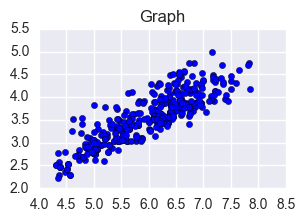

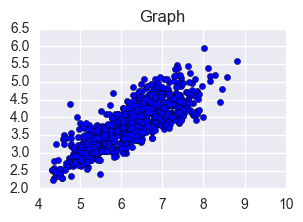

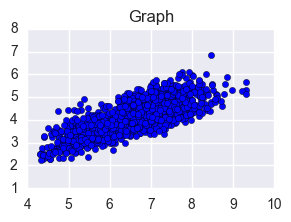

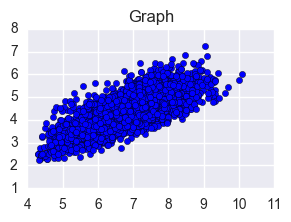

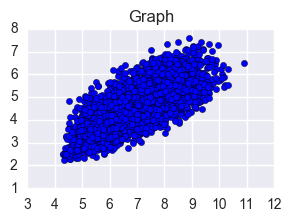

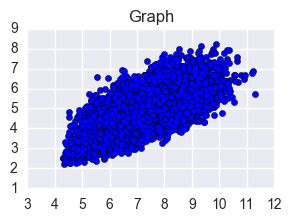

In [119]:
data = datasets.load_iris()
X = data.data[:, :2]
y = data.target
X = X[(y == 0) | (y == 1), :]
y = y[(y == 0) | (y == 1)]

blackbox = LogisticRegression()
blackbox.fit(X, y)
print 'Blackbox score on the random dataset: ', blackbox.score(X, y)

X_random = generate_random(X, data.feature_names[0:2], data_size=1000).values
y_random = blackbox.predict(X_random)
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Whitebox score when trained with random dataset: ', whitebox.score(X, y)

## Applying the algorithm
new_data, new_labels = applyAlgo(X_random, y_random, 0, 1)

## Applying the population generation algorithm
population(new_data, blackbox)

### Heart dataset

Black Box accuracy on the original dataset:  0.733766233766
Whitebox performance when trained on random examples:  0.722943722944
Whitebox score on the first iteration dataset:  0.683982683983
Whitebox score on the first iteration dataset:  0.675324675325
Whitebox score on the first iteration dataset:  0.681818181818
Whitebox score on the first iteration dataset:  0.714285714286
Whitebox score on the first iteration dataset:  0.670995670996
Whitebox score on the first iteration dataset:  0.709956709957


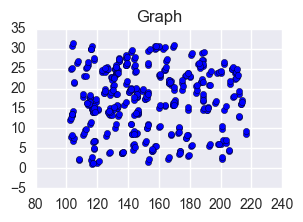

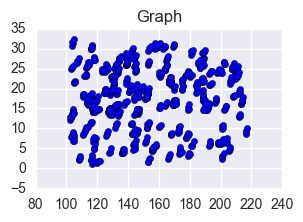

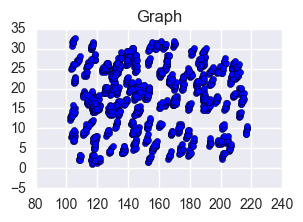

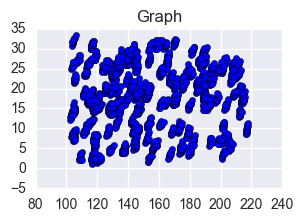

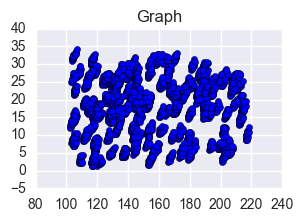

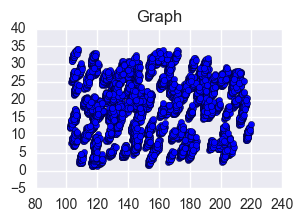

In [116]:
## Data Wrangling
data = pd.read_csv('../data/heart.csv')
data['famhist'] = data['famhist'].map({'Absent': 0, 'Present': 1})
y = data.pop('chd').values
feature_names = data.columns
X = data.values

## Fitting the black box model
blackbox = LogisticRegression()
blackbox.fit(X, y)
print 'Black Box accuracy on the original dataset: ', blackbox.score(X, y)

## Generating random samples
X_random = generate_random(X, feature_names, data_size=1000).values
y_random = blackbox.predict(X_random)

## Whitebox performance with the random dataset
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Whitebox performance when trained on random examples: ', whitebox.score(X, y)

## Applying the algorithm
new_data, new_labels = applyAlgo(X_random, y_random, 0, 1)

population(new_data, blackbox, whitebox=LogisticRegression())